# Предобучение навыков (опций)
link: https://ai.stackexchange.com/questions/13254/what-are-options-in-reinforcement-learning

Нашей задачей будет создание набора опций, каждая из которых должна быть обучена достигать определенные состояния в задаче такси. Для обучения агента воспользуемся реализацией алгоритма Q-обучения.

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 42.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 9.6 MB/s eta 0:00:00


In [55]:
# импортируем файлы и создаем окружение
import gymnasium as gym
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

environment = gym.make('Taxi-v3', render_mode='ansi')
environment.reset()
print(environment.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [56]:
class QLearningAgent:
    def __init__(self, learning_rate, epsilon, gamma, get_legal_actions, seed=1337):
        self.get_legal_actions = get_legal_actions
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))  # when called, non-existent values appear as zeros
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
    
    def Qs(self, state, actions):
        return np.array([self.Q[state][action] for action in actions])

    def V(self, state):
        """Returns max_action Q(state,action) where the max is over legal actions."""
        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return 0.

        return np.max(self.Qs(state, possible_actions))


    def act(self, state):
        """
        Compute the action to take for the current state, including exploration.
        With probability self.epsilon, we should take a random action,
        otherwise - the best policy action (self.getPolicy).
        """

        possible_actions = self.get_legal_actions(state)
        if not possible_actions:
            return None

        if self.rng.random() < self.epsilon:
            action = self.rng.choice(possible_actions)
        else:
            best_action_ind = np.argmax(self.Qs(state, possible_actions))
            action = possible_actions[best_action_ind]
        return action

    def update(self, state, action, next_state, reward, terminated):
        lr, gamma, r, s, a, next_s = self.learning_rate, self.gamma, reward, state, action, next_state
        not_terminated = int(not terminated)
        Q, V = self.Q, self.V
        
        td_error = r + gamma * not_terminated * V(next_s) - Q[s][a]
        Q[s][a] += lr * td_error

### Задание 1 
Разберемся как реализована среда Taxi: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

Создадим 4 окружения аналогичных Taxi, в которых целью агента будет достижение одной из точек: R, G, B, Y соответственно. 

In [57]:
class TaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, target_id, target_reward):
        super().__init__(env)
        #self.locs  = RGBY position
        self._target = self.locs[target_id]
        self._target_reward = target_reward

    def target_reached(self, state) -> bool:
        taxi_pos_x, taxi_pos_y, p_idx, d_idx = list(self.env.decode(state))
        return (taxi_pos_x, taxi_pos_y) == self._target 

    def step(self, action):
        # получаем параметры (state, reward, _, obs),
        # которые передает среда, используя метод step 
        # проверяем является ли состояние завершающим
        # для нашего модифицированного окружения
        # изменяем вознаграждение (reward) и 
        # флаг завершения эпизода (is_done)
        # за каждое действие будем давать вознаграждение 
        # -1, за достижение цели - self._target_reward
        ####### Здесь ваш код ########
        state, reward, terminated, truncated, info = super().step(action)
        taxi_pos_x, taxi_pos_y, p_idx, d_idx = list(self.decode(state))
        
        terminated = ((taxi_pos_x, taxi_pos_y) == self._target) 
        reward = self._target_reward if terminated else -1
        ##############################

        return state, reward, terminated, truncated


Проверим нашу обертку (wrapper), используя случайную стратегию.  Порядок точек должен быть  R, G, Y, B.

In [58]:
for idx in range(4):
    # создаем окружение с заданным целевым состоянием
    ####### Здесь ваш код ########
    # print(environment.locs[idx])
    test_env = TaxiStepWrapper(env = environment, target_id = idx, target_reward = 100)
    terminated = False
    ret = 0
    ##############################
    
    # применяем случайную стратегию,
    # пока эпизод не завершится
    ####### Здесь ваш код ########
    _, _ = test_env.reset()
    while not terminated:
         state, reward, terminated, truncated = test_env.step(test_env.action_space.sample())
         ret += reward
    ##############################

    print(test_env.render())
    print(f"state:{state} reward:{reward} ret:{ret}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

state:12 reward:100 ret:-26
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

state:94 reward:100 ret:70
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

state:404 reward:100 ret:72
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

state:474 reward:100 ret:89


In [59]:
def play_and_train(env, agent, t_max=10 ** 4):
    total_discounted_reward = 0.0
    s, _ = env.reset()
    for t in range(t_max):
        a = agent.act(s)
        try:
            next_s, r, terminated, truncated = env.step(a)
        except ValueError:
            next_s, r, terminated, truncated, _ = env.step(a)
        done  = terminated or truncated
        agent.update(s, a, next_s, r, done)
        s = next_s
        total_discounted_reward += r
        if done: break
    return total_discounted_reward

### Задание 2 
1. Обучим агентов на созданных нами окружениях.
2. Создадим упрощенный вариант опций, каждая опция будет иметь стратегию, множество начальных состояний и множество конечных состояний.

In [60]:
n_actions = environment.action_space.n
seed = 1331
rng = np.random.default_rng(seed)

# параметры, которые будут использовать агенты
params = dict(
    learning_rate=0.1,
    epsilon=0.1, 
    gamma=0.99,
    get_legal_actions=lambda s: range(4),
    seed=rng.integers(100_000_000)
)

# создаем агентов 
agents_for_options = [
    QLearningAgent(**params) for _ in range(4)
]

for idx in range(4):
    # создаем окружение с заданным целевым состоянием, 
    # используя созданных окружения обучаем агентов
    ####### Здесь ваш код ########
    env = TaxiStepWrapper(env = environment, target_id = idx, target_reward = 100)
    print(
        f"total discounted reward for agent {idx}: {play_and_train(env, agents_for_options[idx])}"
    )
    ##############################

total discounted reward for agent 0: 92.0
total discounted reward for agent 1: 69.0
total discounted reward for agent 2: 100.0
total discounted reward for agent 3: 99.0


In [61]:
# реализуем класс опции
class Option:
    def __init__(self, policy, termination_prob, initial, seed=None):
        self.policy = policy
        self.termination_prob = termination_prob
        self.initial_states = initial
        self.rng = np.random.default_rng(seed)

    def can_start(self, state):
        return state in self.initial_states

    def terminate(self, state):
        return self.rng.random() <= self.termination_prob[state]

    def act(self, state):
        return self.policy.act(state)

In [62]:
options = []
for index, agent in enumerate(agents_for_options):
    # Создаем словарь termination_prob, в котором каждому 
    # состоянию  нужно задать вероятность завершения 
    # опции. В нашем случае зададим 1.0 или 0.0, 
    # в зависимости от состояния.
    # Создаем множество initial, добавляем в него 
    # состояния, из которых опция может быть 
    # вызвана (все кроме целевых)
    termination_prob = dict()
    initial_states = set()
    termination_states = set()
    
    ####### Здесь ваш код ########
    tmp_env = TaxiStepWrapper(env = environment, target_id = index, target_reward = 100)
    
    termination_prob = {
        s: 1.0 if tmp_env.target_reached(s) else 0.0 for s in range(environment.observation_space.n) 
    }
    initial_states = set(termination_prob.keys())

    ##############################    

    options.append(
        Option(
            policy=agent, 
            termination_prob=termination_prob,
            initial=initial_states
        )
    )


### Задание 3
Напишем функцию, которая будет запускать опцию и возвращать дисконтированное вознаграждение, опираясь на число совершенных действий
$$ R = r_{1} + \gamma r_{2} + \gamma^{2} r_{3} + \dots + \gamma^{t-1}r_{T}$$

In [70]:
def apply_option(option, gamma, env, debug=False):
    reward = 0
    steps = 0
    alpha = 1
    state = env.unwrapped.s
    if not option.can_start(state):
        raise KeyError
    
    # Взаимодействуем со средой пока опция или окружение 
    # не завершится, считаем дисконтированное 
    # вознаграждение reward (используем steps),
    # также добавим render окружения, при флаге - debug
    
    ####### Здесь ваш код ########
    while True:
        state, reward_t, terminated, truncated, info = env.step(option.act(state))
        terminated |=  option.terminate(state)
        if terminated or truncated:
            break

        reward += reward_t * alpha
        alpha *= gamma
        steps += 1

    if debug:
        print(env.render())
    ##############################

    return state, reward, terminated, truncated

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
# проверим работу метода
env = environment
s, _ = env.reset()

r = apply_option(options[0], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Кажется, что все хорошо, но мы забыли рассмотреть вариант, когда пассажир может находиться в такси! Переведем среду в состояние, где пассажира мы уже подобрали и посмотрим, как ведет себя  одна из опций.

In [72]:
s, _ = env.reset()
env.unwrapped.s = 499
print(env.render())
print("\n" * 2)
r = apply_option(options[0], 0.99, env, debug=True)
print(r[1])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+





+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

-86.46669950929667


### Задание 4
Видим, что опции не обучились действовать в такой ситуации. 
Исправим нашу функцию обучения так, чтобы опции работали корректно для всех возможных состояний среды и сгенерируем их заново.

In [73]:
def play_and_train_modified(env, agent, t_max=10 ** 4, rng=None):
    # Зададим новую функцию play_and_train, которая 
    # в качестве начального состояния выбирает любое 
    # состояние среды,включая и то, когда пассажир 
    # находится в такси
    if rng is None or isinstance(rng, int):
        rng = np.random.default_rng(rng)

    total_discounted_reward = 0.0
    s, _ = env.reset()
    
    # Выбираем случайное состояние среды
    # (используем метод env.uwrapped)
    ####### Здесь ваш код ########
    s = env.unwrapped.observation_space.sample()
    ##############################

    for t in range(t_max):
        a = agent.act(s)
        next_s, r, terminated, truncated = env.step(a)
        done = terminated or truncated
        agent.update(s, a, next_s, r, done)
        s = next_s
        total_discounted_reward += r
        if done: break
            
    return total_discounted_reward


for index in range(4):
    for _ in range(7000):
        wrapped_env = TaxiStepWrapper(
            env=environment, 
            target_id=index, target_reward=50
        )
        play_and_train_modified(
            env=wrapped_env, 
            agent=agents_for_options[index],
            rng=rng
        )


Запустим данную ячейку несколько раз и убедимся, что агент обучился для всех случаев!

In [74]:
env = environment
s, _ = env.reset()

env.unwrapped.s = rng.integers(0, 499)
r = apply_option(options[0], 0.99, env, debug=True)
print(r)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

(10, -10.466174574128354, True, False)


### Объединение в иерархию
Реализуйте иерархию, используя элементарные (опции из одного действия) и обученные опции.

#### Добавим элементарные опции (опции из одного действия: посадка и высадка пассажира):

In [75]:
# для действий 4-5 (pickup, dropoff) создаем 
# элементарные опции:
class OneActionAgent:
    def __init__(self, action):
        self.action = action
    
    def act(self, state):
        return self.action
    
    def update(*args, **kwargs):
        pass

options = options[:4]    
for action in range(4, 6):
    # элементарная опция начинается в любом состоянии, 
    # выполняет любое действие и завершается
    initial = set(range(environment.observation_space.n))
    termination_prob = {
        s: 1.0
        for s in range(environment.observation_space.n)
    }
    options.append(
        Option(policy=OneActionAgent(action), termination_prob=termination_prob, initial=initial)
    )

#### Проверим элементарные опции:

In [77]:
env = environment
s, _ = env.reset()

env.unwrapped.s = rng.integers(0, 499)
_ = apply_option(options[0], 0.99, env, debug=True)
_ = apply_option(options[4], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)



#### Реализуем обертку для окружения, которая вместо действий применяет опции (в качестве входа - список опций):

In [78]:
class OptionTaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, options, gamma=0.99):
        self.options = options
        self.gamma = gamma
        super().__init__(env)

    def step(self, action):
        state, reward, terminated, truncated = apply_option(
            self.options[action], self.gamma, self.unwrapped
        )
        return state, reward, terminated, truncated


In [79]:
baseline_params = dict(
    learning_rate=0.1,
    epsilon=0.1, 
    gamma=0.99,
    get_legal_actions=lambda s: range(environment.action_space.n),
    seed=rng.integers(100_000_000)
)
baseline_agent = QLearningAgent(**baseline_params)



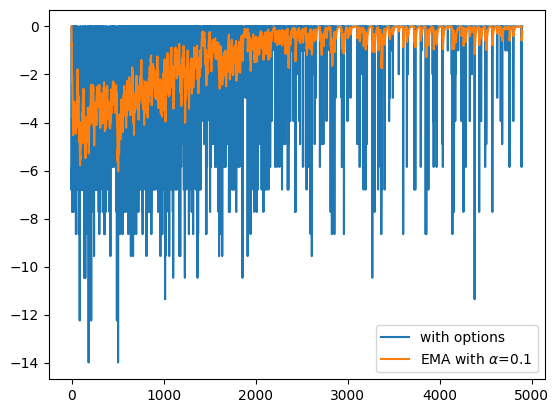

In [86]:
option_agent = QLearningAgent(
    learning_rate=0.1, epsilon=0.2, gamma=0.99,
    get_legal_actions=lambda s: range(len(options)),
    seed=rng.integers(100_000_000)
)
from IPython.display import clear_output
ema = [0]
alpha = 0.1
# создаем окружение, использующее опции
env = OptionTaxiStepWrapper(gym.make('Taxi-v3', render_mode='ansi'), options=options)

rewards = []
baseline_rewards = []

for episode in range(5000):
    r = play_and_train(env=env, agent=option_agent)
    rewards.append(r)
    ema.append(alpha * r + (1 - alpha) * ema[-1])
    # baseline_rewards.append(
    #     play_and_train(env=env, agent=baseline_agent)
    # )

    if episode % 100 == 0:
        clear_output(True)
        option_agent.epsilon *= 0.94
        # baseline_agent.epsilon *= 0.94

        # plt.plot(baseline_rewards, label = "baseline")
        plt.plot(rewards, label = "with options")
        plt.plot(ema, label = r"EMA with $\alpha$=" + str(alpha))

        plt.legend(loc="best")
        plt.show()